# Objective

In this project, we will do classification using Support Vector Machines on [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2).

**Dataset Information:**

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. 

As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

Our main goal is to predict pulsar candidates for facilitate rapid analysis using SVM.

**Attribute Information:**

1. Mean of the integrated profile. 
2. Standard deviation of the integrated profile. 
3. Excess kurtosis of the integrated profile. 
4. Skewness of the integrated profile. 
5. Mean of the DM-SNR curve. 
6. Standard deviation of the DM-SNR curve. 
7. Excess kurtosis of the DM-SNR curve. 
8. Skewness of the DM-SNR curve. 
9. Class 



---



In [0]:
# Loading the important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [0]:
# Loading the dataset
df = pd.read_csv('pulsar_stars.csv')
df.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0


The name of the columns looks messy, so we're going to add underscore between words.

In [0]:
# Fixing messy columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head(3)

,mean_of_the_integrated_profile,standard_deviation_of_the_integrated_profile,excess_kurtosis_of_the_integrated_profile,skewness_of_the_integrated_profile,mean_of_the_dm-snr_curve,standard_deviation_of_the_dm-snr_curve,excess_kurtosis_of_the_dm-snr_curve,skewness_of_the_dm-snr_curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0


# 1. Exploratory Analysis

In [0]:
# Checking the dataset dimensions
df.shape

(17898, 9)

In [0]:
# General information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
mean_of_the_integrated_profile                  17898 non-null float64
standard_deviation_of_the_integrated_profile    17898 non-null float64
excess_kurtosis_of_the_integrated_profile       17898 non-null float64
skewness_of_the_integrated_profile              17898 non-null float64
mean_of_the_dm-snr_curve                        17898 non-null float64
standard_deviation_of_the_dm-snr_curve          17898 non-null float64
excess_kurtosis_of_the_dm-snr_curve             17898 non-null float64
skewness_of_the_dm-snr_curve                    17898 non-null float64
target_class                                    17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


All the input attributes are of float64 types and target variable is int64 containing 0 and 1.

In [0]:
# Statistical characteristics of the dataset
df.describe()

,mean_of_the_integrated_profile,standard_deviation_of_the_integrated_profile,excess_kurtosis_of_the_integrated_profile,skewness_of_the_integrated_profile,mean_of_the_dm-snr_curve,standard_deviation_of_the_dm-snr_curve,excess_kurtosis_of_the_dm-snr_curve,skewness_of_the_dm-snr_curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [0]:
# Checking class distribution
df['target_class'].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

Class 0 has 10 times more information than Class 1. We will try to balance them in the data preprocessing phase using undersampling, oversampling or SMOTE.

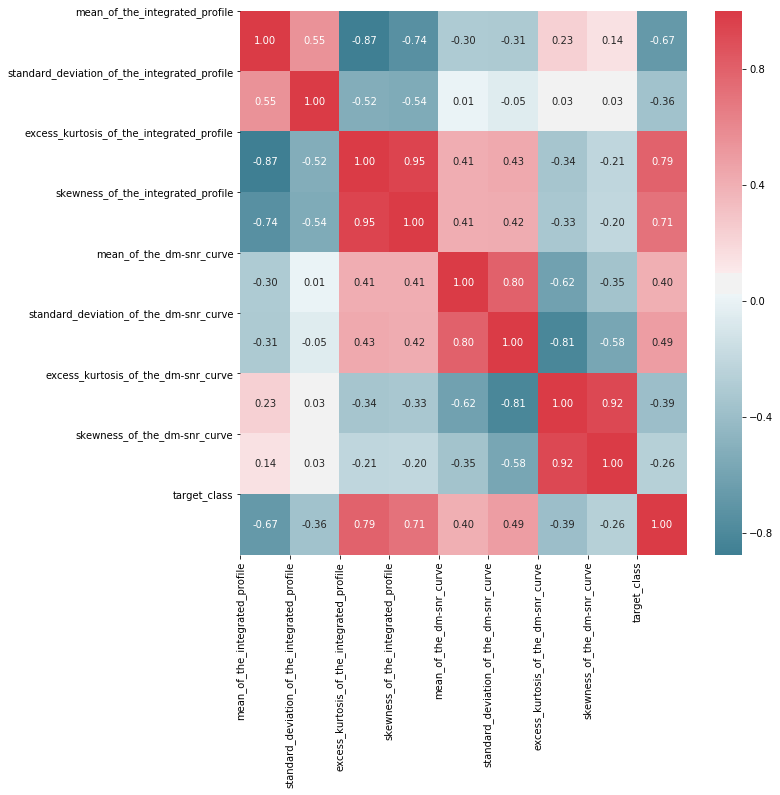

In [0]:
# Correlation between attributes
def HeatMapCorr(df):

    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

HeatMapCorr(df)

You can see the diagonal line through the matrix from the top left to bottom right corners of the matrix shows perfect correlation of each attribute with itself.

## 1.1 Univariative Distribution

Skew refers to a distribution that is assumed Gaussian (normal or bell curve) that is shifted or squashed in one direction or another.

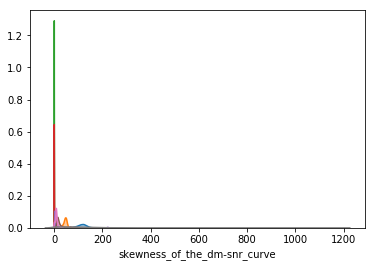

In [0]:
sns.distplot(df['mean_of_the_integrated_profile']); # Left Skew
sns.distplot(df['standard_deviation_of_the_integrated_profile']); # Seems normal distributed but a little bit on right
sns.distplot(df['excess_kurtosis_of_the_integrated_profile']); # normal distributed but a litt bit on right
sns.distplot(df['skewness_of_the_integrated_profile']);
sns.distplot(df['mean_of_the_dm-snr_curve']);
sns.distplot(df['standard_deviation_of_the_dm-snr_curve']);
sns.distplot(df['excess_kurtosis_of_the_dm-snr_curve']);
sns.distplot(df['skewness_of_the_dm-snr_curve']);

## 1.2 COMPARING MEAN & STANDARD DEVIATION BETWEEN ATTRIBUTES FOR TARGET CLASSES

[GREEN == STAR , RED == NOTSTAR]


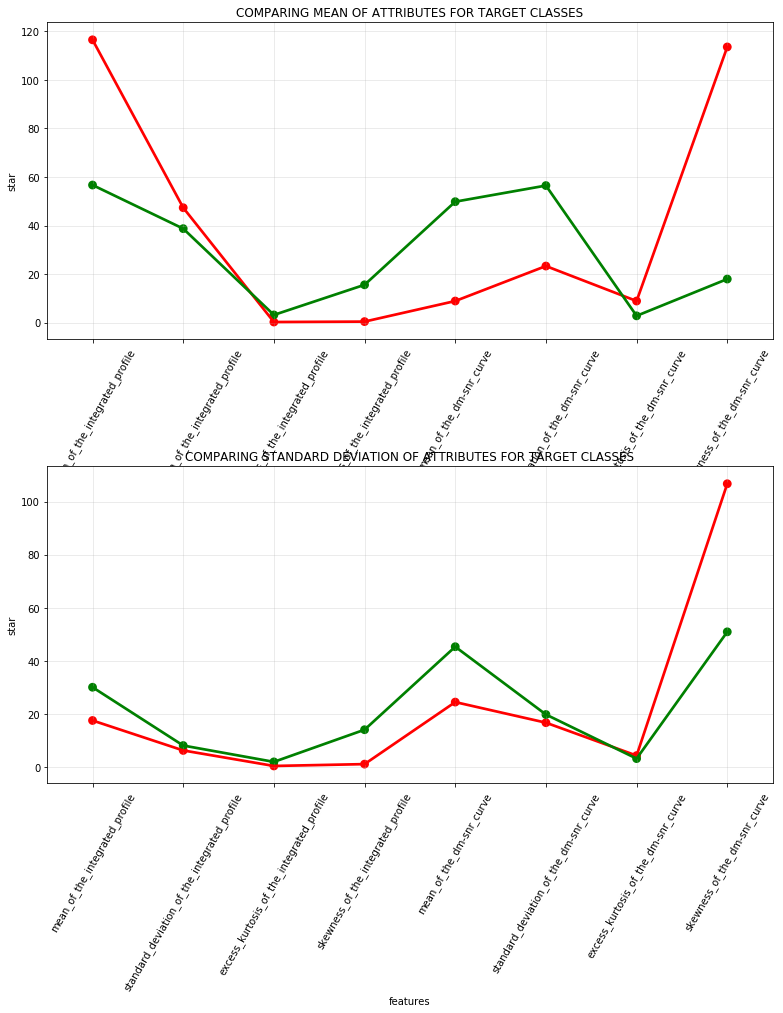

In [0]:
# Green = 1, Red = 0
compare = df.groupby("target_class")[['mean_of_the_integrated_profile', 'standard_deviation_of_the_integrated_profile', 
                      'excess_kurtosis_of_the_integrated_profile', 'skewness_of_the_integrated_profile',
                                        'mean_of_the_dm-snr_curve', 'standard_deviation_of_the_dm-snr_curve', 'excess_kurtosis_of_the_dm-snr_curve',
                                        'skewness_of_the_dm-snr_curve']].mean().reset_index()
compare1 = df.groupby("target_class")[['mean_of_the_integrated_profile', 'standard_deviation_of_the_integrated_profile', 
                      'excess_kurtosis_of_the_integrated_profile', 'skewness_of_the_integrated_profile',
                                        'mean_of_the_dm-snr_curve', 'standard_deviation_of_the_dm-snr_curve', 'excess_kurtosis_of_the_dm-snr_curve',
                                        'skewness_of_the_dm-snr_curve']].std().reset_index()
compare = compare.drop("target_class",axis =1)
compare1 = compare1.drop("target_class",axis =1)

compare_mean = compare.transpose().reset_index()
compare_mean = compare_mean.rename(columns={'index':"features", 0:"not_star", 1:"star"})
plt.figure(figsize=(13,14))
plt.subplot(211)
sns.pointplot(x= "features",y="not_star",data=compare_mean,color="r")
sns.pointplot(x= "features",y="star",data=compare_mean,color="g")
plt.xticks(rotation =60)
plt.xlabel("")
plt.grid(True,alpha=.3)
plt.title("COMPARING MEAN OF ATTRIBUTES FOR TARGET CLASSES")

compare_std = compare1.transpose().reset_index()
compare_std = compare_std.rename(columns={'index':"features", 0:"not_star", 1:"star"})
plt.subplot(212)
sns.pointplot(x= "features",y="not_star",data=compare_std,color="r")
sns.pointplot(x= "features",y="star",data=compare_std,color="g")
plt.xticks(rotation =60)
plt.grid(True,alpha=.3)
plt.title("COMPARING STANDARD DEVIATION OF ATTRIBUTES FOR TARGET CLASSES")
plt.subplots_adjust(hspace =.4)
print ("[GREEN == STAR , RED == NOTSTAR]")
plt.show()

# 2. Data Preprocessing

In [0]:
# Checking null values
df.isnull().sum()

mean_of_the_integrated_profile                  0
standard_deviation_of_the_integrated_profile    0
excess_kurtosis_of_the_integrated_profile       0
skewness_of_the_integrated_profile              0
mean_of_the_dm-snr_curve                        0
standard_deviation_of_the_dm-snr_curve          0
excess_kurtosis_of_the_dm-snr_curve             0
skewness_of_the_dm-snr_curve                    0
target_class                                    0
dtype: int64

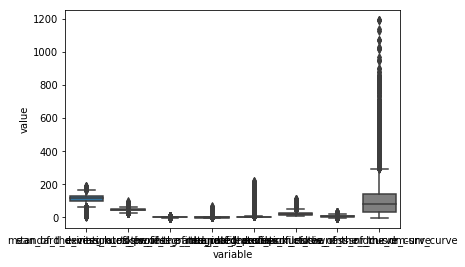

In [0]:
# Checking for outliers
sns.boxplot(x="variable", y="value", data=pd.melt(df[df.columns[0:8]]))

In [0]:
# Splitting the data into training and test set
X = df.iloc[:, 0:8].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)

In [0]:
# Checking class distribution
np.bincount(y_train)

array([13025,  1293], dtype=int64)

I'll use SMOTE for fixing the imblanced data. This is an over-sampling method which creates synthetic samples of minority class.

In this dataset, majority class is 0 and minority class is 1. So, SMOTE will make the minority class 1 equal to majority class 0.

In [0]:
# Fitting SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [0]:
# Checking the distribution again
np.bincount(y_train)

array([13025, 13025], dtype=int64)

Now, we have equal class distribution.

In [0]:
# Checking the shape
X_train.shape

(26050, 8)

Before SMOTE, X_train had 17,898 observations. Now, it has 26,050.

## 2.1. Data Scaling

It is time to apply StandardScaler() on the training and test set.

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 2.2. Parameter Tuning

I want to achieve more accurate results. So, I'll do some parameter tuning and we'll compare the kfold and models results without parameter tuning and tuned parameters.

I'll use GridSearchCV for tuning. First, let's disucss the parameters:
    kernl: rbf, linear, poly, sigmoid, precomputed
    C: Penalty parameter. 
    If C is larger, the optimization will choose smaller-margin hyperplane.
    Else if C is smaller, the optimization will choose larger-margin hyperplane.
    gamma: If auto, then value is 1 / (no. of features)
           If scale, then value is 1 / (no. of features * X.std())

In [0]:
# Function to tune SVM parameters
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 10] 
    kernels = ['rbf', 'linear']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


best_params = svc_param_selection(X_train, y_train, 10)

The best params I got are: C = 10, gamma = 0.001, kernel = 'rbf'

## 2.3. KFold cross validation

In [0]:
# Before Parameter Tuning
kfold_clf_1 = SVC(random_state = 7)
kfold_1 = KFold(n_splits=10, random_state=7)
cv_results_1 = cross_val_score(kfold_clf_1, X_train, y_train, cv=kfold_1, scoring='accuracy')
cv_results_1.mean()

0.9464107485604607

In [0]:
# After Parameter Tuning
kfold_clf_2 = SVC(C = 10, gamma = 0.001, random_state = 7)
kfold_2 = KFold(n_splits=10, random_state=7)
cv_results_2 = cross_val_score(kfold_clf_2, X_train, y_train, cv=kfold_2, scoring='accuracy')
cv_results_2.mean()

0.9381190019193857

After tuned parameters, cross validation is showing less accuracy than the one above on the training set.

# 3. Modeling

In [0]:
# Before Parameter Tuning
clf_1 = SVC(random_state = 7)
clf_1.fit(X_train, y_train)
y_pred_1 = clf_1.predict(X_test)
confusion_matrix(y_test, y_pred_1)
accuracy_score(y_test, y_pred_1)

0.9689944134078212

In [0]:
# After Parameter Tuning
clf_2 = SVC(C = 10, gamma = 0.001, random_state = 7)
clf_2.fit(X_train, y_train)
y_pred_2 = clf_2.predict(X_test)
confusion_matrix(y_test, y_pred_2)
accuracy_score(y_test, y_pred_2)

0.9712290502793296

That's better. The conclusion of the tests is that, our model is not over-fitted. Because test set accuracy is greater than the cross validation accuracy.

If training accuracy is highter than the testing, it means you have an overfit model.

# 4. Visualization

As, there is not any easy way to plot the decision boundary and graph for multi-dimensional data. So, for getting an idea, we'll use dimensionality reduction technique PCA, so we could visualize.

In [0]:
# PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [0]:
# Fitting the model after PCA
clf_pca = SVC(C = 10, gamma = 0.001, random_state = 7)
clf_pca.fit(X_train, y_train)
confusion_matrix(y_test, clf_pca.predict(X_test))

array([[3086,  148],
       [  52,  294]], dtype=int64)

In [0]:
# Visualising the Training set results
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf_pca.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Training set)')
plt.legend()
plt.show()

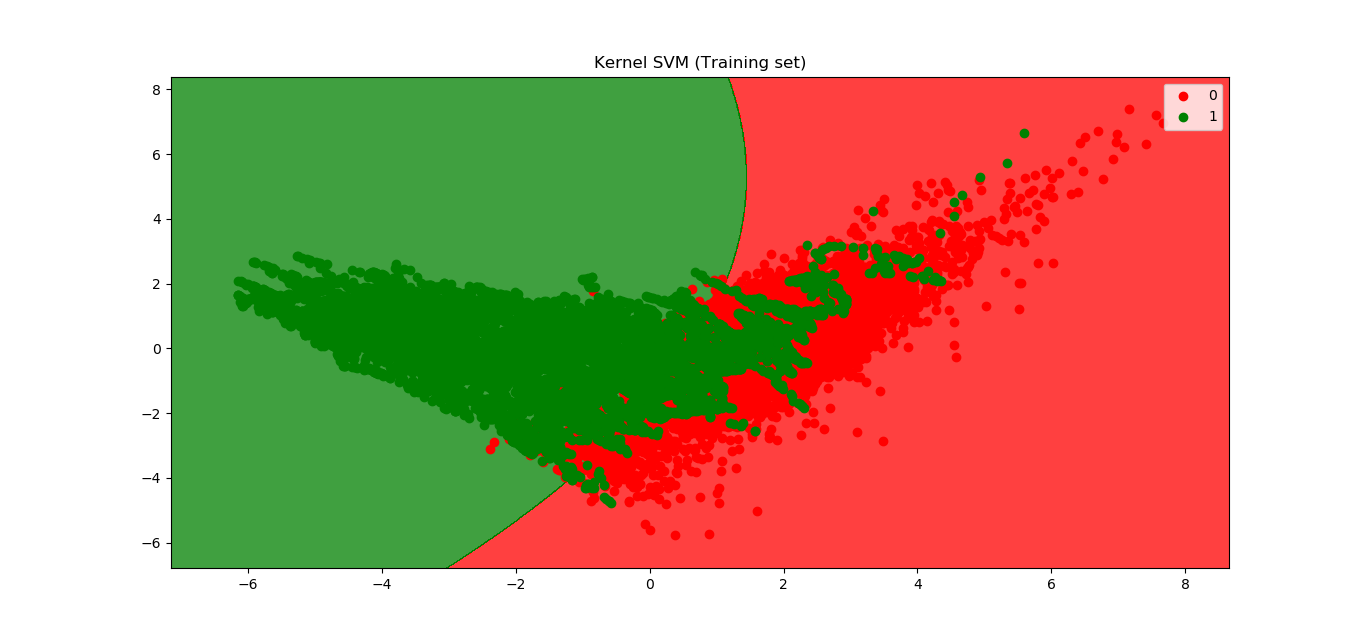

In [1]:
from IPython.display import Image
Image("training.png")

In [0]:
# Visualising the test set results
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf_pca.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Test set)')
plt.legend()
plt.show()

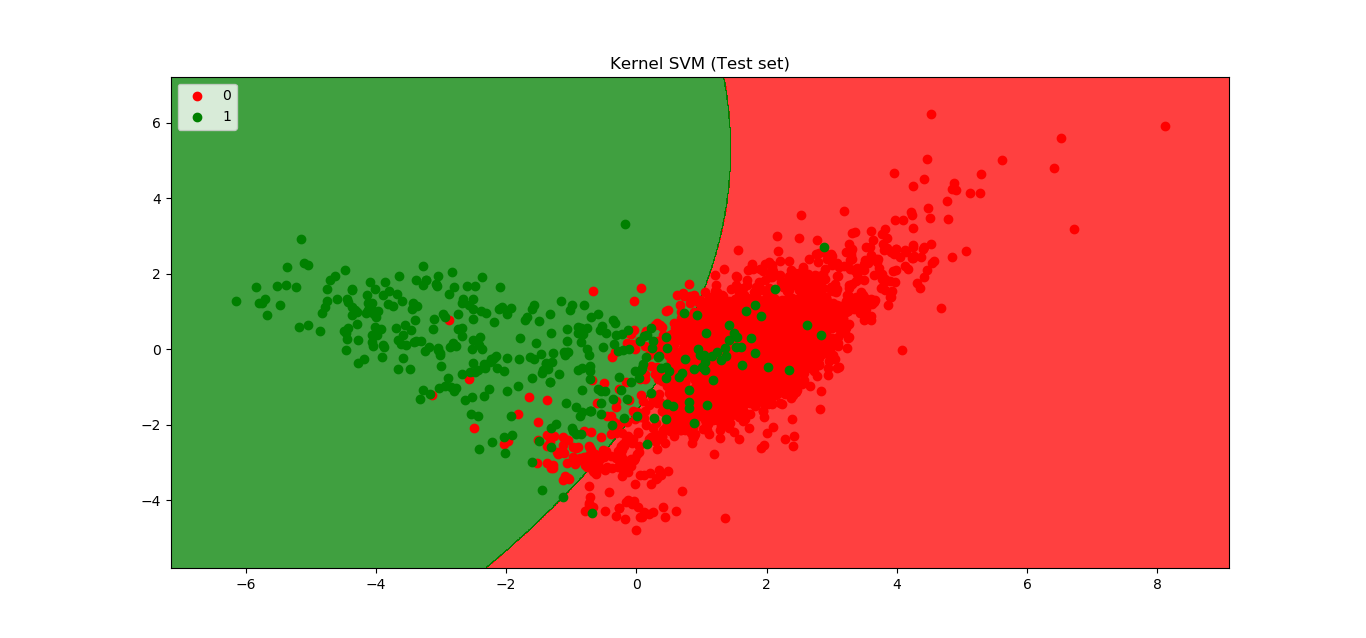

In [2]:
from IPython.display import Image
Image("test.png")

# Conclusion

This is the end of support vector machines test on this dataset. Because the dataset is non-linearly separable, so we can get much better accuracy using decison tree, random forest, or XGBoost.